In [1]:
%%javascript
utils.load_extension('collapsible_headings/main')
utils.load_extension('hide_input/main')
utils.load_extension('autosavetime/main')
utils.load_extension('execute_time/ExecuteTime')
utils.load_extension('code_prettify/code_prettify')
utils.load_extension('scroll_down/main')
utils.load_extension('jupyter-js-widgets/extension')

<IPython.core.display.Javascript object>

## Blend: a family of data augmentation techniques

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

I've created some code we need to import to be able to use these new data augmentations with the fastai library. Hopefully, one day they will be part of the fastai library and won't need to do this.

In [7]:
from exp.nb_new_data_augmentation import *

In [4]:
size=128
bs = 32
partial_data = .05
path = untar_data(URLs.IMAGENETTE_160); path

PosixPath('/home/oguiza/.fastai/data/imagenette-160')

In [5]:
data = (ImageList.from_folder(path)
        .use_partial_data(partial_data)
        .split_by_folder(valid='val')
        .label_from_folder()
        .transform(size=size)
        .databunch(bs=bs, num_workers=4)
        .presize(size, scale=(0.35, 1))
        .normalize(imagenet_stats))
data

ImageDataBunch;

Train: LabelList (635 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
n03445777,n02102040,n03394916,n03028079,n03000684
Path: /home/oguiza/.fastai/data/imagenette-160;

Valid: LabelList (34 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
n01440764,n02102040,n03394916,n03425413,n02979186
Path: /home/oguiza/.fastai/data/imagenette-160;

Test: None

In [6]:
learn = Learner(data, models.resnet34())

### GridZero

TypeError: _blend() got an unexpected keyword argument 'blend'

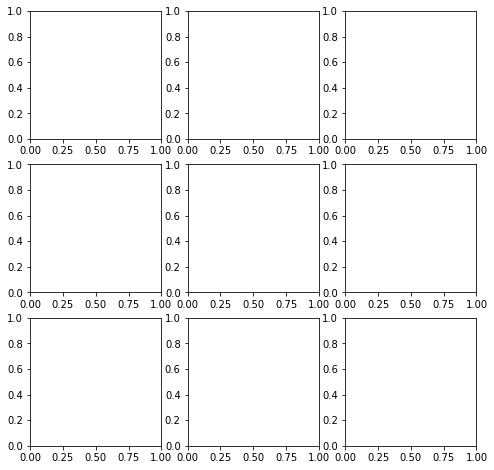

In [8]:
from exp.nb_new_data_augmentation import *
learn.data.train_ds.tfms = [gridzero(size=.05, alpha=.2)]
learn.show_single_img_tfms();

### GridCut

In [ ]:
from exp.nb_new_data_augmentation import *
learn.data.train_ds.tfms = [gridcut(size=0.05, alpha=1., proba=True)]
learn.show_single_img_tfms();

### GridMix

In [ ]:
from exp.nb_new_data_augmentation import *
learn.data.train_ds.tfms = [gridmix(size=0.05, alpha=.2, proba=False)]
learn.show_single_img_tfms();

### RandomZero

In [ ]:
from exp.nb_new_data_augmentation import *
learn.data.train_ds.tfms = [randzero(size=0.05, alpha=.2, proba=True)]
learn.show_single_img_tfms();

### RandomCut

In [ ]:
from exp.nb_new_data_augmentation import *
learn.data.train_ds.tfms = [randcut(size=0.05, alpha=.2, proba=False)]
learn.show_single_img_tfms();

### RandomMix

In [ ]:
from exp.nb_new_data_augmentation import *
learn.data.train_ds.tfms = [randmix(size=0.05, alpha=.2, proba=False)]
learn.show_single_img_tfms();

### Blend

In [ ]:
from exp.nb_new_data_augmentation import *
learn.data.train_ds.tfms = [blend(size=0.05, alpha=.1, blend='noise', grid=True, same=True, proba=True)]
learn.show_single_img_tfms();

## Multi-image transforms

There are at least a couple of things multi-image data transforms have in common: 

- they combine 2 or more images to create a new synthetic image
- unlike previous techniques like cutout, the entire image provides informative pixels. 

In this case I'm creating a databunch without any transforms (other than size) so that it's easier to visualize the real impact of each transformation.

This is for demo purposes only. When you use the new data augmentations, you'll be able to decide whether you want to use them jointly with single-image transforms, or just on their own.

In [ ]:
data = (ImageList.from_folder(path)
        .split_by_folder(valid='val')
        .label_from_folder()
        .transform(size=size) # <-- no transforms 
        .databunch(bs=bs, num_workers=4)
        .presize(size, scale=(0.35, 1))
        .normalize(imagenet_stats))

I've created a new function (show_multi_img_tfms) that you can use to easily visualize images created by a callback.

As you'll see, new data augmentation images are sometimes not realistic to us, but they are helpful to improve performance in vision tasks.

### Mixup (Zhang, 2018)

https://arxiv.org/abs/1710.09412

Mixup blends two images drawn at random from our training data. A weight λ (between .5-1) is assigned to the first sample, and 1-λ to the second one. 
Despite its simplicity, mixup allows a new state-of-the-art performance in the CIFAR-10, CIFAR- 100, and ImageNet-2012 image classification datasets.

In [ ]:
learn = Learner(data, models.resnet34()).mixup()
learn.show_multi_img_tfms();

Isn't it weird that this increases performance??

### Ricap (Takahashi, 2018)

RICAP (Random Image Cropping and Patching) crops four training images and patches them to construct a new training image; it selects images and determines the cropping sizes randomly, where the size of the final image is identical to that of the original image.

RICAP achieves a new state-of-the-art test error of 2.19% on CIFAR-10. We also confirmed that deep CNNs with RICAP achieve better results on classification tasks using CIFAR-100 and ImageNet and an image-caption retrieval task using Microsoft COCO.

It's applied in the following way:
- a pixel coordinate in the image is randomly selected. That creates 4 areas within an image.
- 4 regions from different images are cropped and patched to create a new image. 

In [ ]:
learn = Learner(data, models.resnet34()).ricap(beta=.1).show_multi_img_tfms()

In [ ]:
learn = Learner(data, models.resnet34()).ricap(beta=1.).show_multi_img_tfms()

### Cutmix (Yun, 2019)

https://arxiv.org/abs/1905.04899

Cutmix is similar to Cutout, as a single patch is cut and pasted into a different training image.

CutMix consistently outperforms the state-of-the-art augmentation strategies on CIFAR and ImageNet classification tasks, as well as on the ImageNet weakly- supervised localization task.


In [ ]:
learn = Learner(data, models.resnet34()).cutmix(alpha=.1).show_multi_img_tfms()

In [ ]:
learn = Learner(data, models.resnet34()).cutmix(alpha=1.).show_multi_img_tfms()

## How to train using data augmentation?

It's super easy! The only thing you need to do is: 

1. First you will create your ImageDataBunch as you would normally do.
You'll need to decide if you want to apply single-image transformations when you create the databunch. If you decide to use it, just add:

In [ ]:
# single-image transforms
tfms = get_transforms()
data = (ImageList.from_folder(path)
        .split_by_folder(valid='val')
        .label_from_folder()
        .transform(tfms=tfms, size=size) # <-- single-img transforms
        .databunch(bs=bs, num_workers=4)
        .presize(size, scale=(0.35, 1))
        .normalize(imagenet_stats))

2. The you will create the learner as usual, but you will add to it the selected multi-image transform you have selected (mixup, ricap or cutmix). You can only select one of these new data augmentations at a time.

In [ ]:
# multi-image transforms
learn = Learner(data, models.resnet34()).cutmix()

That's it!!. 
We can now visualize our images just to check everything's working well.

In [ ]:
learn.show_multi_img_tfms();

You can also do both in a single step

In [ ]:
learn = Learner(data, models.resnet34(), metrics=error_rate).cutmix().show_multi_img_tfms()

## Scheduled tfm

### Single parameter

In [ ]:
from exp.nb_new_data_augmentation import *
learn = Learner(data, models.resnet34(), metrics=accuracy)

tfm_fn = partial(gridcut, size=.05, proba=True)
sch_param='alpha'
sch_val = .25
sch_iter = None
sch_func = partial(annealing_cos) # annealing_cos, None = annealing_linear, cosine_annealing
plot = True
test = False
sch_tfm_cb = partial(TfmScheduler, tfm_fn=tfm_fn, sch_param=sch_param, sch_val=sch_val, 
                      sch_iter=sch_iter, sch_func=sch_func, plot=plot, test=test)
learn.callback_fns.append(sch_tfm_cb)
for cb in learn.callback_fns: print(cb, '\n')
learn.fit_one_cycle(30)

In [ ]:
learn = Learner(data, models.resnet34(), metrics=accuracy, loss_func = LabelSmoothingCrossEntropy())
learn.fit_one_cycle(30)

In [ ]:
xb, yb = learn.data.one_batch()

In [ ]:
from exp.nb_xresnet_sa import *
xresnet34(sa=True)(xb)

### Multiple parameters

In [ ]:
from exp.nb_new_data_augmentation import *
from fastai.callbacks.misc import StopAfterNBatches

tfm_fn = partial(gridmix, size=.05, proba=True)
sch_param=['alpha', 'size']
sch_val = [(.5, 0), (.2, .4)]
sch_iter = [.5, .7]
sch_func = annealing_cos # annealing_cos, None = annealing_linear
plot = True
test = False
sch_tfm_cb = partial(TfmScheduler, tfm_fn=tfm_fn, sch_param=sch_param, sch_val=sch_val, 
                      sch_iter=sch_iter, sch_func=sch_func, plot=plot, test=test)


learn = Learner(data, models.resnet34(), metrics=accuracy)
learn.callback_fns.append(sch_tfm_cb)
learn.callbacks.append(StopAfterNBatches(n_batches=2))
for cb in learn.callback_fns: print(cb, '\n')
learn.fit_one_cycle(5)

## Sandbox

In [ ]:

xb, yb = learn.data.one_batch()

In [ ]:
bs = 32
data = (ImageList.from_folder(path)
        .use_partial_data(0.010)
        .split_by_folder(valid='val')
        .label_from_folder()
        .transform(size=size)
        .databunch(bs=bs, num_workers=4)
        .presize(size, scale=(0.35, 1))
        .normalize(imagenet_stats))
data

In [ ]:
import math

class TfmScheduler(LearnerCallback):
    
    def __init__(self,
                 learn: Learner,
                 tfm_fn: Callable,
                 sch_param: str,
                 sch_vals: StartOptEnd,
                 sch_iters: Optional[StartOptEnd] = None,
                 func: Optional[AnnealFunc] = None,
                 **kwargs: Any):

        super().__init__(learn)
        self.batches = math.ceil(len(data.train_ds)/data.train_dl.batch_size)
        self.tfm_fn = tfm_fn
        self.sch_param = sch_param
        self.start_val, self.end_val = (
            sch_vals[0], sch_vals[1]) if is_tuple(sch_vals) else (sch_vals, 0)
        self.sch_iters = sch_iters
        if func is None: self.func = annealing_linear if is_tuple(vals) else annealing_no
        else: self.func = func

    def on_train_begin(self, n_epochs: int, epoch: int, **kwargs: Any):
        total_iters = n_epochs * self.batches
        print('n_epochs, epoch, batches, total_iters', n_epochs, epoch, self.batches, total_iters)
        if self.sch_iters is None: start_iter, end_iter = (0, total_iters)
        else:
            start_iter, end_iter = (self.sch_iters[0],self.sch_iters[1]) if is_tuple(
                                        self.sch_iters) else (0, self.sch_iters)
            if isinstance(start_iter, float): start_iter = int(start_iter * total_iters)
            if isinstance(end_iter, float): end_iter = int(end_iter * total_iters)
        eff_iters = end_iter - start_iter
        self.scheduler = MyScheduler(total_iters, sch_vals, sch_iters=sch_iters, func=func)
        self.scheduler.n = 0

    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        param = self.scheduler.step()
        if isinstance(self.tfm_fn, functools.partial): 
            fn = self.tfm_fn.func.func
            self.tfm_fn.keywords[self.sch_param] = param
            kw = self.tfm_fn.keywords
        else: 
            kw = {self.sch_param: param}
            fn = self.tfm_fn.func
        new_input = fn(last_input, **kw)
        display(Image(new_input[0]))
        return {'last_input': new_input, 'last_target': last_target}

In [ ]:
from exp.nb_new_data_augmentation import *
tfm_fn = partial(gridzero)
sch_param='alpha'
sch_vals = (0., 1)
sch_iters = (.2, .8)
func = annealing_cos
learn = Learner(data, models.resnet34())
learn.callback_fns.append(partial(TfmScheduler, tfm_fn=tfm_fn, sch_param=sch_param, 
                                  sch_vals=sch_vals, sch_iters=None, func=func))
learn.fit_one_cycle(5)

In [ ]:
fn = tfm_fn.func
fn(alpha=)

In [ ]:
if isinstance(tfm_fn, functools.partial): fn = tfm_fn.func.func
else: fn = tfm_fn.func
inspect.getfullargspec(fn)

In [ ]:
fn

In [ ]:
inspect.getfullargspec(blender.func)

In [ ]:
xb, yb = learn.data.one_batch()

In [ ]:
from exp.nb_new_data_augmentation import *
out = _blender(xb[0], size=.05, alpha=.2, blend='mix', grid=False, same=True)
Image(out)

In [ ]:
alpha = 1
lambd_ = []
for i in range(1000):
    lambd = np.random.beta(alpha, alpha)
    lambd = max(lambd, 1- lambd)
    lambd_.append(1-lambd)
plt.hist(lambd_, 100)
plt.show()
print(np.mean(lambd_))

In [ ]:
alpha = 10
lambd_ = []
for i in range(1000):
    lambd = np.random.beta(alpha, alpha)
    #lambd = max(lambd, 1- lambd)
    lambd_.append(lambd)
plt.hist(lambd_, 100)
plt.show()

In [ ]:
alpha = .2
patch_len = 400

lambd = np.random.beta(alpha, alpha)
lambd = max(lambd, 1- lambd)
patch_ids = np.random.choice(np.arange(patch_len), int(patch_len * (1 - lambd)), replace=False)
len(patch_ids)

In [ ]:
n = 10000
start = 0
width = .5
x = sp.stats.uniform.rvs(size=n, loc = start, scale=width)
plt.hist(x, 100)
plt.show()
print(x.mean(), x.std(), sp.stats.skew(x), sp.stats.kurtosis(x))

In [ ]:
x = sp.stats.norm.rvs(size=10000,loc=0,scale=1)
plt.hist(x, 100)
plt.show()
print(x.mean(), x.std(), sp.stats.skew(x), sp.stats.kurtosis(x))

In [ ]:
x = sp.stats.expon.rvs(scale=1,loc=0,size=1000)
x = x / x.max()
plt.hist(x, 100)
plt.show()
print(x.mean(), x.std(), sp.stats.skew(x), sp.stats.kurtosis(x))

In [ ]:
data_expon = expon.rvs(scale=1,loc=0,size=1000)

#### Uniform (alpha = 1., fixed_proba=False)

In [ ]:
import scipy as sp
alpha = 1
x = np.random.beta(alpha, alpha, size=(10000, 1)) * .5
#x = np.concatenate((x, 1 - x), axis=1).min(1)
plt.hist(x, 100)
plt.show()
print(x.mean(), x.std(), sp.stats.skew(x), sp.stats.kurtosis(x))

#### Gaussian (alpha=

In [ ]:
import scipy as sp
alpha = 5
x = np.random.beta(alpha, alpha, size=(10000, 1))
plt.hist(x, 100)
plt.show()
print(x.mean(), x.std(), sp.stats.skew(x), sp.stats.kurtosis(x))

In [ ]:
import scipy as sp
x = np.random.normal(size=10000)
x = (x - x.min()) / (x.max() - x.min()) * .5
plt.hist(x, 100)
plt.show()
print(x.mean(), x.std(), sp.stats.skew(x), sp.stats.kurtosis(x))

#### Lambda

In [ ]:
import scipy as sp
alpha = .3
x = np.random.beta(1, alpha, size=(10000, 1))
x = np.concatenate((x, 1 - x), axis=1).min(1)
plt.hist(x, 100)
plt.show()
print(x.mean(), x.std(), sp.stats.skew(x), sp.stats.kurtosis(x))

In [ ]:
size = .05
alpha = .25
proba_type = 'beta' # '', 

## Blend

In [ ]:


class RicapCallback(LearnerCallback):
    "Callback that creates the ricap input and target."
    def __init__(self, learn:Learner, beta:float=.3, stack_y:bool=True, 
                 rand:bool=True, shuffle:bool=True):
        super().__init__(learn)
        self.beta,self.stack_y,self.rand,self.shuffle = beta,stack_y,rand,shuffle

    def on_train_begin(self, **kwargs):
        if self.stack_y and self.shuffle: self.learn.loss_func = RicapLoss(self.learn.loss_func)

    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        "Applies ricap to `last_input` and `last_target` if `train`."
        if not train: return
        # get the image size
        I_x, I_y = last_input.size()[2:]
        
        # draw a boundary position (w, h)
        w = int(np.round(I_x * np.random.beta(self.beta, self.beta)))
        h = int(np.round(I_y * np.random.beta(self.beta, self.beta)))
        if self.rand:
            w_ = [w, I_x - w, w, I_x - w]
            h_ = [h, h, I_y - h, I_y - h]
        else:
            h_from = [0, 0, h, h]
            h_to = [h, h, I_y, I_y]
            w_from = [0, w, 0, w]
            w_to = [w, I_x, w, I_x]
        
        # select and crop four images
        cropped_images = {}
        bs = last_input.size(0)
        c_ = torch.zeros((bs, 4)).float().to(last_input.device)
        W_ = torch.zeros(4).float().to(last_input.device)
        for k in range(4):
            if self.shuffle: idx = torch.randperm(bs).to(last_input.device)
            else: idx = torch.linspace(0, bs - 1, steps=bs).to(dtype=torch.int64, device=last_input.device)
            if self.rand:
                x_k = np.random.randint(0, I_x - w_[k] + 1)
                y_k = np.random.randint(0, I_y - h_[k] + 1)
                cropped_images[k] = last_input[idx][:, :, x_k:x_k + w_[k], y_k:y_k + h_[k]]
                c_[:, k] = last_target[idx].float() # cropping labels
                W_[k] = w_[k] * h_[k] / (I_x * I_y) # cropping weights
            else:
                cropped_images[k] = last_input[idx][:, :, h_from[k]:h_to[k], w_from[k]:w_to[k]]
                c_[:, k] = last_target[idx].float()
                W_[k] = (h_to[k] - h_from[k]) * (w_to[k] - w_from[k]) / (I_x * I_y)
            print(W_[k])
        # patch cropped images
        if self.rand:
            patched_images = torch.cat(
                (torch.cat((cropped_images[0], cropped_images[1]), 2),
                 torch.cat((cropped_images[2], cropped_images[3]), 2)), 3)  #.cuda()
        else:
            patched_images = torch.cat(
                (torch.cat((cropped_images[0], cropped_images[2]), 2),
                 torch.cat((cropped_images[1], cropped_images[3]), 2)), 3) 
            

        # modify last target
        if self.shuffle:
            new_target = torch.cat((last_target[:,None].float(), c_,
                                    W_[None].repeat(last_target.size(0), 1)), 
                                   dim=1)
        else: new_target = last_target
        #print(new_target)
        #return
        #print(new_target.shape)
        #print(last_target[:,None].float().shape)
        #print(c_.shape)
        #print(W_[None].repeat(last_target.size(0), 1).shape)
        #print()
        
        return {'last_input': patched_images, 'last_target': new_target}

    def on_train_end(self, **kwargs):
        if self.stack_y and self.shuffle: self.learn.loss_func = self.learn.loss_func.get_old()


def ricap(learn:Learner, beta:float=.3, stack_y:bool=True, rand:bool=True) -> Learner:
    "Add ricap https://arxiv.org/pdf/1811.09030.pdf to `learn`."
    learn.callback_fns.append(partial(RicapCallback, beta=beta, 
                                      stack_y=stack_y, rand=rand))
    return learn


setattr(ricap, 'cb_fn', RicapCallback)
Learner.ricap = ricap

In [ ]:
def _blend(x, size:tuple=(.5, .2), alpha:float=.3, fixed_proba:float=0., 
           blend_type:str='cut', grid:bool=True,  same_size:bool=True):
    ''' Modifies one or multiple subregions of an image
        Parameters:
        size: 
            int tuple(height pixels, wide pixels), float tuple (height % img, wide % img)
            int (pixels) or float (percent_tuple)
        alpha: proba that each patch is modified from np.random.beta(alpha, alpha)
        fixed_proba: proba that each individual patch is modified. If >0 overrides alpha.
        blend_type: 'zero', 'noise', 'mix', 'cut' or 'rand'(any of the previous)
        grid: True patches will be part of a grid, so they won't overlap
        same_size: True all grid cells will have approx the same size, otherwise random'''

    if size == 0 or (alpha == 0 and fixed_proba == 0): return x
    if not isinstance(size, tuple): size = (size, size)
    if isinstance(size[0], float): h = int(size[1] * x_size[-2])
    else: h = size[0]
    if isinstance(size[1], float): w = int(size[0] * x_size[-1])
    else: w = size[1]
    if w == 0 or h == 0: return x
    x_size = x.shape
    new_x = x.clone()
    
    # patches that will be modified
    n_patches = (x_size[0] // h, x_size[1] // w)
    patch_len = n_patches[0] * n_patches[1]
    if fixed_proba != 0:
        patch_ids = np.arange(patch_len)[np.random.rand(patch_len) <= fixed_proba]
    else:
        lambd = np.random.beta(alpha, alpha)
        lambd = max(lambd, 1- lambd)
        patch_ids = np.random.choice(np.arange(patch_len), 
                                     int(patch_len * (1 - lambd)), 
                                     replace=False)
    
    if blend.lower() == 'rand': _blend = np.random.choice(['zero', 'noise', 'mix', 'cut'])
    else: _blend = blend.lower()

    if grid: patches = get_x1_coords(x_size, n_patches, same_size=same_size)
    for i in patch_ids:
        #x1 coordinates
        if grid: bby1, bby2, bbx1, bbx2 = patches[i]
        else: bby1, bby2, bbx1, bbx2 = get_x1_rand_coords(x_size, n_patches, w, h)
        # Blend
        if _blend == 'zero': new_x[..., bby1:bby2, bbx1:bbx2] = 0
        if _blend == 'noise': 
            noise = x.new(np.random.rand(bby2 - bby1, bbx2 - bbx1))
            new_x[..., bby1:bby2, bbx1:bbx2] = noise
        else: 
            #x2 coordinates
            ccy1, ccy2, ccx1, ccx2 = get_x2_coords(x_size, bby1, bby2, bbx1, bbx2)
            x2 = x[..., ccy1:ccy2, ccx1:ccx2]
            if _blend == 'mix':
                x1 = x[..., bby1:bby2, bbx1:bbx2]
                new_x[..., bby1:bby2, bbx1:bbx2] = x1 * .5 + x2 * .5
            if _blend == 'cut':
                new_x[..., bby1:bby2, bbx1:bbx2] = x2
    return new_x

blender = TfmPixel(_blend)

In [ ]:
#export 

class BlendLoss(nn.Module):
    "Adapt the loss function `crit` to go with blend data augmentations."

    def __init__(self, crit, reduction='mean'):
        super().__init__()
        if hasattr(crit, 'reduction'):
            self.crit = crit
            self.old_red = crit.reduction
            setattr(self.crit, 'reduction', 'none')
        else:
            self.crit = partial(crit, reduction='none')
            self.old_crit = crit
        self.reduction = reduction

    def forward(self, output, target):
        #print('loss output target input:', output.shape, target.shape)
        if target.ndim == 2:# and target.shape[-1] >1:
            n_mod_patches = (target.shape[-1] - 1) // 2
            c_ = target[:, 1:n_mod_patches + 1]
            W_ = target[:, n_mod_patches + 1:]
            loss = [W_[:, k] * self.crit(output, c_[:, k].long()) for k in range(n_mod_patches)]
            d = torch.mean(torch.stack(loss))
        else: d = self.crit(output, target)
        if self.reduction == 'mean': return d.mean()
        elif self.reduction == 'sum': return d.sum()
        return d

    def get_old(self):
        if hasattr(self, 'old_crit'): return self.old_crit
        elif hasattr(self, 'old_red'):
            setattr(self.crit, 'reduction', self.old_red)
            return self.crit

In [ ]:
class BlendCallback(LearnerCallback):
    "Callback that creates the blend input and target."
    def __init__(self, learn:Learner, 
                 size:tuple=(.1, .1), alpha:float=1., fixed_proba:float=0., 
                 blend_type:str='cut', same_size:bool=True,
                 same_crop:bool=True, same_image:bool=False):
        ''' Modifies one or multiple subregions of an image
        Parameters:
        size: 
            int tuple(height pixels, wide pixels), float tuple (height % img, wide % img)
            int (pixels) or float (percent_tuple)
            None full image
        alpha: proba that each patch is modified from np.random.beta(alpha, alpha)
        fixed_proba: proba that each individual patch is modified. If >0 overrides alpha.
        blend_type: 'zero', 'noise', 'mix', 'cut' or 'rand'(any of the previous)
        same_size: True - all patches will have approx the same size, otherwise random
        same_crop: cropping subregion will be the same as input subregion, otherwise different
        same_image: False - cropping image will be different from input image, otherwise same
        '''
        assert blend_type in ['zero', 'noise', 'mix', 'cut', 'random'], \
        print("make sure you select one of these blend_types: 'zero', 'noise', 'mix', 'cut', 'random'")
        super().__init__(learn)
        self.size,self.alpha,self.fixed_proba,self.blend_type = size,alpha,fixed_proba,blend_type
        self.same_size,self.same_crop,self.same_image = same_size,same_crop,same_image

    def on_train_begin(self, **kwargs):
        if not self.same_image: self.learn.loss_func = BlendLoss(self.learn.loss_func)

    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        "Applies blend to `last_input` and `last_target` if `train`."
        if not train: return {'last_input': last_input, 'last_target': last_target}
        if self.alpha == 0 and self.fixed_proba == 0: 
            return {'last_input': last_input, 'last_target': last_target}

        x_size = last_input.size()
        bs = x_size[0] # batch size
        i_h, i_w = x_size[2:] # image height, width
        if not isinstance(self.size, tuple): self.size = (self.size, self.size)
        p_h, p_w = self.size # patch percent height, width
        if p_h == 1 or isinstance(p_h, float): h = int(p_h * i_h) # patch height in pixels
        else: h = p_h
        if p_w == 1 or isinstance(p_w, float): w = int(p_w * i_w) # patch width in pixels
        else: w = p_w
        if w == 0 or h == 0: return {'last_input': last_input, 'last_target': last_target}
        patched_images = last_input.clone()

        # patches that will be modified
        n_patches = (i_h // h, i_w // w)
        patch_len = n_patches[0] * n_patches[1]
        patches = get_x1_coords(x_size, n_patches, same_size=self.same_size)
        if self.fixed_proba != 0:
            lambd = self.fixed_proba
        else:
            lambd = np.random.beta(self.alpha, self.alpha)
            lambd = max(lambd, 1- lambd)
        if patch_len == 1: patch_ids = [0]
        elif self.fixed_proba != 0:
            patch_ids = np.arange(patch_len)[np.random.rand(patch_len) <= lambd]
        else:
            patch_ids = np.random.choice(np.arange(patch_len), int(patch_len * (1 - lambd)), replace=False)
        n_mod_patches = len(patch_ids)
        if n_mod_patches == 0: return {'last_input': last_input, 'last_target': last_target}
        mod_patches = [patches[i] for i in patch_ids]
        c_ = torch.zeros((bs, n_mod_patches)).float().to(last_input.device) # patch labels
        W_ = torch.zeros(n_mod_patches).float().to(last_input.device) # new weights
        idx = torch.linspace(0, bs - 1, steps=bs).to(dtype=torch.int64, device=last_input.device)
        if self.blend_type.lower() == 'random': _blend = np.random.choice(['zero', 'noise', 'mix', 'cut'])
        else: _blend = self.blend_type.lower()
        for j, patch in enumerate(mod_patches):
            #x1 coordinates
            bby1, bby2, bbx1, bbx2 = patch
            # Blend
            if _blend == 'zero': patched_images[..., bby1:bby2, bbx1:bbx2] = 0
            if _blend == 'noise': 
                noise = last_input.new(np.random.rand(bby2 - bby1, bbx2 - bbx1))
                patched_images[..., bby1:bby2, bbx1:bbx2] = noise
            else: 
                if not self.same_image: idx = torch.randperm(bs).to(last_input.device)
                #x2 coordinates
                if self.same_crop: 
                    x2 = last_input[idx][..., bby1:bby2, bbx1:bbx2]
                else:
                    ccy1, ccy2, ccx1, ccx2 = get_x2_coords(x_size, bby1, bby2, bbx1, bbx2)
                    x2 = last_input[idx][..., ccy1:ccy2, ccx1:ccx2]
                if _blend == 'mix':
                    x1 = last_input[..., bby1:bby2, bbx1:bbx2]
                    if self.size == (1, 1): 
                        patched_images[..., bby1:bby2, bbx1:bbx2] = x1 * lambd + x2 * (1 - lambd)
                    else: patched_images[..., bby1:bby2, bbx1:bbx2] = x1 * .5 + x2 * .5
                if _blend == 'cut':
                    patched_images[..., bby1:bby2, bbx1:bbx2] = x2
            W_[j] = (bby2 - bby1) * (bbx2 - bbx1) / (i_w * i_h)
            c_[:, j] = last_target[idx].float()
        # modify last target
        if not self.same_image and n_mod_patches > 0:
            new_target = torch.cat((last_target[:,None].float(), c_, W_[None].repeat(bs, 1)), dim=1)
        else: new_target = last_target
        return {'last_input': patched_images, 'last_target': new_target}

    def on_train_end(self, **kwargs):
        if not self.same_image: self.learn.loss_func = self.learn.loss_func.get_old()


def blend_mgr(learn:Learner, size:tuple=(.1, .1), alpha:float=1., 
          fixed_proba:float=0., blend_type:str='cut', 
          same_size:bool=True, same_crop:bool=True, same_image:bool=False) -> Learner:
    learn.callback_fns.append(partial(BlendCallback, size=size, alpha=alpha, 
                                      fixed_proba=fixed_proba, blend_type=blend_type, 
                                      same_size=same_size, same_crop=same_crop, same_image=same_image))
    return learn

setattr(blend_mgr, 'cb_fn', BlendCallback)
Learner.blend_mgr = blend_mgr

In [ ]:
#RICAP
size = .5
alpha = 1
fixed_proba = 1     # this will override alpha
blend_type = 'cut' # 'zero', 'noise', 'mix', 'cut', 'random'
same_size = False
same_crop = False    # only with 'mix' and 'cut'
same_image = False    # only with 'mix' and 'cut'

learn = Learner(data, models.resnet34()).blend(
    size=size,
    alpha=alpha,
    fixed_proba=fixed_proba,
    blend_type=blend_type,
    same_size=same_size,
    same_crop=same_crop,
    same_image=same_image).show_multi_img_tfms()

In [ ]:
from exp.nb_new_data_augmentation import *
learn = Learner(data, models.resnet34(), metrics=accuracy)

size = .1
alpha = .2
fixed_proba = 0.
blend_type = 'noise'
same_size = True
same_crop = True
same_image = False
tfm_fn = partial(blend, size=size, alpha=alpha, fixed_proba=fixed_proba, blend_type=blend_type,
                 same_size=same_size, same_crop=same_crop, same_image=same_image)

sch_param='alpha'
sch_val = (.25, .5)
sch_iter = (0, .3)
sch_func = annealing_cos # annealing_cos, None = annealing_linear, cosine_annealing
plot = True
test = False  # if True this will stop training in the first mini-batch
sch_tfm_cb = partial(TfmScheduler, tfm_fn=tfm_fn, sch_param=sch_param, sch_val=sch_val, 
                      sch_iter=sch_iter, sch_func=sch_func, plot=plot, test=test)
learn.callback_fns.append(sch_tfm_cb)
for cb in learn.callback_fns: print(cb, '\n')
learn.fit_one_cycle(1)

In [ ]:
tfm_fn.func.cb_fn

In [ ]:
xb,yb = learn.data.one_batch()

In [ ]:
partial(BlendCallback, **{
        'size': 0.1,
        'alpha': 0.0,
        'fixed_proba': 0.0,
        'blend_type': 'noise',
        'same_size': True,
        'same_crop': True,
        'same_image': False
    }).on_batch_begin(xb, yb, True)

In [ ]:
tfm_fn = partial(BlendCallback, size=size, alpha=alpha, fixed_proba=fixed_proba, blend_type=blend_type,
                 same_size=same_size, same_crop=same_crop, same_image=same_image)

tfm_fn.keywords

In [ ]:
new_input, new_target = BlendCallback.on_batch_begin(last_input=xb,last_target=yb,train=True)

In [ ]:
blender(learn, size=(.1, .1), alpha=1., fixed_proba=0., 
                 blend_type='cut', same_size=True,
                 same_crop=True, same_image=False).on_batch_begin(last_input=xb,last_target=yb,train=True)

In [ ]:
tfm_fn = partial(BlendCallback, size=size, alpha=alpha, fixed_proba=fixed_proba, blend_type=blend_type,
                 same_size=same_size, same_crop=same_crop, same_image=same_image)